In [3]:
#          Copyright Rein Halbersma 2020-2021.
# Distributed under the Boost Software License, Version 1.0.
#    (See accompanying file LICENSE_1_0.txt or copy at
#          http://www.boost.org/LICENSE_1_0.txt)

# Re-implementing Marcel Wieting's LinkedIn post
# https://www.linkedin.com/pulse/web-scraping-relative-age-effect-professional-football-marcel-wieting/?trackingId=d8UqaacWy%2FaNdTYFhh4MsQ%3D%3D

import re

import bs4
import lxml
from typing import Optional, Tuple

from etiget import etiget

transfermarkt_url = 'https://www.transfermarkt.com'
eu_leagues = '/wettbewerbe/europa'

def fetch_eu_leagues(page: str) -> bs4.element.ResultSet:
    response = etiget(transfermarkt_url + eu_leagues + f'?page={page}')
    assert response.status_code == 200
    return (bs4
        .BeautifulSoup(response.content, 'lxml')
        .find('div', class_='responsive-table')
        .find('tbody')
        .find_all('tr', class_=re.compile('odd|even'))
    )

def extract_league_link(league: bs4.element.Tag) -> str:
    return (league
        .find_all('td')[2]
        .find('a')
        .get('href')
    )

def fetch_clubs(league: str) -> bs4.element.ResultSet:
    response = etiget(transfermarkt_url + league)
    assert response.status_code == 200
    return (bs4
        .BeautifulSoup(response.content, 'lxml')
        .find('div', class_='responsive-table')
        .find('tbody')
        .find_all('tr', class_=re.compile('odd|even'))
    )

def extract_club_link(club: bs4.element.Tag) -> str:
    return (club
        .find('td')
        .find('a')
        .get('href')
    )

def fetch_players(club: str) -> bs4.element.ResultSet:
    response = etiget(transfermarkt_url + club)
    try:
        soup = bs4.BeautifulSoup(response.content, 'lxml')
        try:
            return (soup
                .find('div', class_='responsive-table')
                .find('tbody')
                .find_all('tr', class_=re.compile('odd|even'))
            )
        except Exception as e:
            print(f'{e}: empty squad for club == {club}')
            return []
    except:
        print(f'Error {response.status_code}: not finding club == {club}')
        return []

def extract_player_data(player: bs4.element.Tag) -> Tuple[Optional[str], Optional[str], Optional[str], Optional[str], Optional[str]]:
    try:
        number = (player
            .find('div', class_='rn_nummer')
            .text
        )
    except:
        number = None
    try:
        name = (player
            .find('td', itemprop='athlete')
            .text
        )
    except:
        name = None
    try:
        position = (player
            .find('td', class_='posrela')
            .find_all('tr')[1]
            .find('td')
            .text
        )
    except:
        position = None
    try:
        birth_date = (player
            .find_all('td', recursive=False)[3]
            .text
        )
    except:
        birth_date = None
    try:
        market_value = (player
            .find('td', class_='rechts hauptlink')
            .text
        )
    except:
        market_value = None
    return number, name, position, birth_date, market_value

In [2]:
table = fetch_eu_leagues("1")

In [138]:
data = []
for d in table:
    tr = d.find_all("tr")
    for row in tr:
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols]
        data.append([ele for ele in cols if ele]) 

In [139]:
import pandas as pd
import matplotlib.pyplot as plt

In [140]:
extract_league_link(table[0])

'/premier-league/startseite/wettbewerb/GB1'

In [222]:
link = "/fc-barcelona/startseite/verein/131"

In [223]:
# Positionごとの人数
players = fetch_players(link)

data = []
for i in range(len(players)):
    d = extract_player_data(players[i])
    print(d)
    data.append(d[2])

('1', 'Marc-André ter Stegen', 'Goalkeeper', 'Apr 30, 1992 (30)', '€30.00m\xa0\xa0')
('13', 'Neto', 'Goalkeeper', 'Jul 19, 1989 (32)', '€3.00m\xa0\xa0')
('36', 'Arnau Tenas', 'Goalkeeper', 'May 30, 2001 (21)', '€1.50m\xa0\xa0')
('4', 'Ronald Araújo', 'Centre-Back', 'Mar 7, 1999 (23)', '€50.00m\xa0\xa0')
('24', 'Eric García', 'Centre-Back', 'Jan 9, 2001 (21)', '€18.00m\xa0\xa0')
('15', 'Clément Lenglet', 'Centre-Back', 'Jun 17, 1995 (26)', '€12.00m\xa0\xa0')
('22', 'Óscar Mingueza', 'Centre-Back', 'May 13, 1999 (23)', '€6.00m\xa0\xa0')
('3', 'Gerard Piqué', 'Centre-Back', 'Feb 2, 1987 (35)', '€5.00m\xa0\xa0')
('23', 'Samuel Umtiti', 'Centre-Back', 'Nov 14, 1993 (28)', '€2.00m\xa0\xa0')
('18', 'Jordi Alba', 'Left-Back', 'Mar 21, 1989 (33)', '€9.00m\xa0\xa0')
('31', 'Álex Balde', 'Left-Back', 'Oct 18, 2003 (18)', '€4.00m\xa0\xa0')
('2', 'Sergiño Dest', 'Right-Back', 'Nov 3, 2000 (21)', '€18.00m\xa0\xa0')
('-', 'Moussa Wagué', 'Right-Back', 'Oct 4, 1998 (23)', '€1.50m\xa0\xa0')
('8', 'Dani

In [224]:
param = set(data)
param

{'Central Midfield',
 'Centre-Back',
 'Centre-Forward',
 'Defensive Midfield',
 'Goalkeeper',
 'Left Winger',
 'Left-Back',
 'Right Winger',
 'Right-Back'}

In [30]:
vdict = pd.Series(data).value_counts(normalize=True).to_dict()

newDict = {"Goalkeeper":vdict["Goalkeeper"],
           "Centre-Back":vdict['Centre-Back'],
           'Right-Back':vdict['Right-Back'],
           'Left-Back':vdict['Left-Back'],
           'Defensive Midfield':vdict['Defensive Midfield'],
           'Central Midfield':vdict['Central Midfield'],
           'Attacking Midfield':vdict['Attacking Midfield'],
           'Right Winger':vdict['Right Winger'],
           'Left Winger':vdict['Left Winger'],
           'Centre-Forward':vdict['Centre-Forward'],
          }
params = newDict.keys()
values = list(newDict.values())
values = list(map(lambda i:round(i*100,2),values))

print(values)
print(params)
# print(newDict)

[11.54, 15.38, 11.54, 7.69, 7.69, 15.38, 7.69, 7.69, 3.85, 7.69]
dict_keys(['Goalkeeper', 'Centre-Back', 'Right-Back', 'Left-Back', 'Defensive Midfield', 'Central Midfield', 'Attacking Midfield', 'Right Winger', 'Left Winger', 'Centre-Forward'])


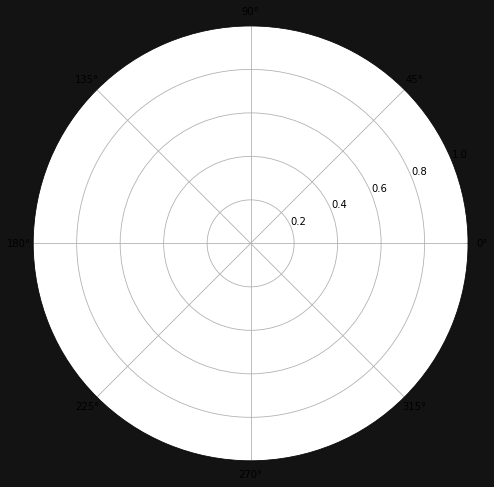

In [31]:
import requests
from bs4 import BeautifulSoup
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import seaborn as sns
from mplsoccer import VerticalPitch,FontManager,add_image
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors
from urllib.request import urlopen
from PIL import Image

from matplotlib.patches import Circle, Rectangle, Arc
fig,axes = plt.subplots(figsize=(15,8),subplot_kw={'projection': 'polar'})
fig.set_facecolor("#131313")

<BarContainer object of 8 artists>

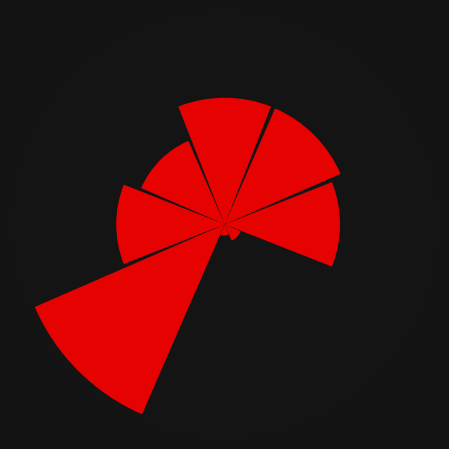

In [32]:
fig,axes = plt.subplots(figsize=(15,8),subplot_kw={'projection': 'polar'})
fig.set_facecolor("#131313")
axes.set_facecolor("#141414")

axes.spines["polar"].set_visible(False)
axes.spines["polar"].set_color("green")
axes.set_xticklabels([])
axes.set_yticks([])
axes.grid(False)


# axes[x].set_xticklabels([])
# axes[x].set_yticks([])
# axes[x].grid(False, alpha=0)

axes.bar(np.arange(8)*(2*np.pi/8), 
         np.random.uniform(low=0.0, high=100.0, size=8), 
         width=.75, bottom=0, 
         alpha=0.9, color="red", zorder=3)

In [143]:
from mplsoccer import PyPizza,FontManager
font_normal = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/static/"
                           "Roboto-Regular.ttf?raw=true"))
font_italic = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/static/"
                           "Roboto-Italic.ttf?raw=true"))
font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/static/"
                         "Roboto-Medium.ttf?raw=true"))
slice_colors = ["#4361ee"] * 1 + ["#ee9b00"] * 3 + ["#43aa8b"]*3 + ["#ae2012"] * 3 
text_colors = ["#FFFFFF"] * 10

In [185]:
# baker = PyPizza(
#     params=vkeys,                  # list of parameters
#     straight_line_color="#ededed",  # color for straight lines
#     straight_line_limit=25,
#     straight_line_lw=1,             # linewidth for straight lines
#     last_circle_lw=1,               # linewidth of last circle
#     other_circle_lw=1,              # linewidth for other circles
#     other_circle_ls="-.",           # linestyle for other circles
# )

baker = PyPizza(
    params=params,                  # list of parameters
    background_color="#131313",     # background color
    straight_line_color="#EBEBE9",  # color for straight lines
    straight_line_limit=25,
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=0,               # linewidth of last circle
    other_circle_lw=0,              # linewidth for other circles
    inner_circle_size=3.5             # size of inner circle
)

len(values)


11

In [186]:
textColor = "#ffffff"

fig, ax = baker.make_pizza(
    values,                          # list of values
    figsize=(8, 8.5),                # adjust figsize according to your need
    color_blank_space="same",        # use same color to fill blank space
    slice_colors=slice_colors,       # color for individual slices
    value_colors=text_colors,        # color for the value-text
    value_bck_colors=slice_colors,   # color for the blank spaces
    blank_alpha=0.4,                 # alpha for blank-space colors
    param_location=28,
    kwargs_slices=dict(
        facecolor="#131313", edgecolor="#000000",
        zorder=2, linewidth=1
    ),                   # values to be used when plotting slices
    kwargs_params=dict(
        color=textColor, fontsize=12,
        va="center", alpha=.9
    ),                   # values to be used when adding parameter
    kwargs_values=dict(
        color=textColor, fontsize=12,
        zorder=3,
        bbox=dict(
            edgecolor="#111111", facecolor="#6CABDD",
            boxstyle="Roundtooth,pad=0.5", lw=1.5
        )
    )                    # values to be used when adding parameter-values
)
fig.patches.extend([
    plt.Rectangle(
        (0.29, 0.9225), 0.025, 0.021, fill=True, color="#1a78cf",
        transform=fig.transFigure, figure=fig
    ),
    plt.Rectangle(
        (0.42, 0.9225), 0.025, 0.021, fill=True, color="#ff9300",
        transform=fig.transFigure, figure=fig
    ),
    plt.Rectangle(
        (0.55, 0.9225), 0.025, 0.021, fill=True, color="#43aa8b",
        transform=fig.transFigure, figure=fig
    ),
    plt.Rectangle(
        (0.68, 0.9225), 0.025, 0.021, fill=True, color="#d70232",
        transform=fig.transFigure, figure=fig
    ),
])
# add title
fig.text(
    0.511, 0.975, "Bayern", size=16,
    ha="center", fontproperties=font_bold.prop, color=textColor
)

# add subtitle
fig.text(
    0.515, 0.953,
    "Squad Balance in terms of Position | Season 2021-22",
    size=13,
    ha="center", fontproperties=font_bold.prop, color=textColor
)

# add credits
CREDIT_1 = "data: transfermarkt.com"
CREDIT_2 = "inspired by: @Worville, @FootballSlices"

fig.text(
    0.99, 0.02, f"{CREDIT_1}\n{CREDIT_2}", size=9,
    fontproperties=font_italic.prop, color=textColor,
    ha="right"
)

# add text
fig.text(  
    0.32, 0.925, "GK                 DF                 MF               FW", size=14,
    fontproperties=font_bold.prop, color=textColor
)
# URL = "https://github.com/andrewRowlinson/mplsoccer-assets/blob/main/fdj_cropped.png?raw=true"
# wikiのエンブレムをクリックして右下クリックー＞EMbded
# URL = "https://upload.wikimedia.org/wikipedia/en/thumb/e/eb/Manchester_City_FC_badge.svg/1200px-Manchester_City_FC_badge.svg.png"
# URL = "https://upload.wikimedia.org/wikipedia/en/thumb/4/47/FC_Barcelona_%28crest%29.svg/1200px-FC_Barcelona_%28crest%29.svg.png"
#https://upload.wikimedia.org/wikipedia/en/thumb/a/a7/Paris_Saint-Germain_F.C..svg/1200px-Paris_Saint-Germain_F.C..svg.png
URL = "https://upload.wikimedia.org/wikipedia/commons/thumb/1/1b/FC_Bayern_M%C3%BCnchen_logo_%282017%29.svg/1200px-FC_Bayern_M%C3%BCnchen_logo_%282017%29.svg.png"
fdj_cropped = Image.open(urlopen(URL))
ax_image = add_image(
    fdj_cropped, fig, left=0.4478, bottom=0.4315, width=0.13, height=0.127
)   # these values might differ when you are plotting

team = input("team: ????")
plt.savefig(f'/work/output/{team}.png', dpi=200, bbox_inches="tight",facecolor="#131313")

TypeError: object of type 'int' has no len()

In [225]:
# 市場価値
players = fetch_players(link)

data = []
for i in range(len(players)):
    d = extract_player_data(players[i])
    data.append({d[2]:d[4]})

data

[{'Goalkeeper': '€30.00m\xa0\xa0'},
 {'Goalkeeper': '€3.00m\xa0\xa0'},
 {'Goalkeeper': '€1.50m\xa0\xa0'},
 {'Centre-Back': '€50.00m\xa0\xa0'},
 {'Centre-Back': '€18.00m\xa0\xa0'},
 {'Centre-Back': '€12.00m\xa0\xa0'},
 {'Centre-Back': '€6.00m\xa0\xa0'},
 {'Centre-Back': '€5.00m\xa0\xa0'},
 {'Centre-Back': '€2.00m\xa0\xa0'},
 {'Left-Back': '€9.00m\xa0\xa0'},
 {'Left-Back': '€4.00m\xa0\xa0'},
 {'Right-Back': '€18.00m\xa0\xa0'},
 {'Right-Back': '€1.50m\xa0\xa0'},
 {'Right-Back': '€1.00m\xa0\xa0'},
 {'Defensive Midfield': '€9.00m\xa0\xa0'},
 {'Central Midfield': '€80.00m\xa0\xa0'},
 {'Central Midfield': '€60.00m\xa0\xa0'},
 {'Central Midfield': '€60.00m\xa0\xa0'},
 {'Central Midfield': '€20.00m\xa0\xa0'},
 {'Central Midfield': '€7.00m\xa0\xa0'},
 {'Central Midfield': '€6.00m\xa0\xa0'},
 {'Left Winger': '€60.00m\xa0\xa0'},
 {'Left Winger': '€45.00m\xa0\xa0'},
 {'Left Winger': '€8.00m\xa0\xa0'},
 {'Right Winger': '€30.00m\xa0\xa0'},
 {'Right Winger': '€20.00m\xa0\xa0'},
 {'Centre-Forward': '€

In [226]:
import math
market_values = {}
df = pd.DataFrame(data) 
for p in param:
    pos_values = df[p].dropna().values
    new_values = []
    for v in pos_values:
        if v[5].isdigit():
            new_values.append(v)
    market_values[p] = new_values
    
market_values

{'Right Winger': ['€30.00m\xa0\xa0', '€20.00m\xa0\xa0'],
 'Centre-Back': ['€50.00m\xa0\xa0', '€18.00m\xa0\xa0', '€12.00m\xa0\xa0'],
 'Centre-Forward': ['€35.00m\xa0\xa0', '€15.00m\xa0\xa0'],
 'Defensive Midfield': [],
 'Goalkeeper': ['€30.00m\xa0\xa0'],
 'Left Winger': ['€60.00m\xa0\xa0', '€45.00m\xa0\xa0'],
 'Central Midfield': ['€80.00m\xa0\xa0',
  '€60.00m\xa0\xa0',
  '€60.00m\xa0\xa0',
  '€20.00m\xa0\xa0'],
 'Left-Back': [],
 'Right-Back': ['€18.00m\xa0\xa0']}

In [227]:
for p in param:
    pos = market_values[p]
    new_pos = []
    for v in pos:
        new_v = float(v[1:6])
        new_pos.append(new_v)
    market_values[p] = sum(new_pos)
market_values

{'Right Winger': 50.0,
 'Centre-Back': 80.0,
 'Centre-Forward': 50.0,
 'Defensive Midfield': 0,
 'Goalkeeper': 30.0,
 'Left Winger': 105.0,
 'Central Midfield': 220.0,
 'Left-Back': 0,
 'Right-Back': 18.0}

In [228]:
values = list(market_values.values())
from scipy import stats
# values = stats.zscore(values)*10 + 50
print(values)
params = market_values.keys()
print(params)

[50.0, 80.0, 50.0, 0, 30.0, 105.0, 220.0, 0, 18.0]
dict_keys(['Right Winger', 'Centre-Back', 'Centre-Forward', 'Defensive Midfield', 'Goalkeeper', 'Left Winger', 'Central Midfield', 'Left-Back', 'Right-Back'])


In [231]:
# baker = PyPizza(
#     params=vkeys,                  # list of parameters
#     straight_line_color="#ededed",  # color for straight lines
#     straight_line_limit=25,
#     straight_line_lw=1,             # linewidth for straight lines
#     last_circle_lw=1,               # linewidth of last circle
#     other_circle_lw=1,              # linewidth for other circles
#     other_circle_ls="-.",           # linestyle for other circles
# )

baker = PyPizza(
    params=params,                  # list of parameters
    min_range=[0]*len(params), max_range=[70]*len(params),
    background_color="#131313",     # background color
    straight_line_color="#EBEBE9",  # color for straight lines
    straight_line_limit=125,
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=0,               # linewidth of last circle
    other_circle_lw=0,              # linewidth for other circles
    inner_circle_size=3.5             # size of inner circle
)

slice_colors = ["#4361ee"] * 2 + ["#ee9b00"] * 3 + ["#43aa8b"]*3 + ["#ae2012"] * 3 
text_colors = ["#FFFFFF"] * 11

In [232]:
textColor = "#ffffff"

fig, ax = baker.make_pizza(
    values,                          # list of values
    figsize=(8, 8.5),                # adjust figsize according to your need
    color_blank_space="same",        # use same color to fill blank space
    slice_colors=slice_colors,       # color for individual slices
    value_colors=text_colors,        # color for the value-text
    value_bck_colors=slice_colors,   # color for the blank spaces
    blank_alpha=0.4,                 # alpha for blank-space colors
    param_location=133,
    kwargs_slices=dict(
        facecolor="#131313", edgecolor="#000000",
        zorder=2, linewidth=1
    ),                   # values to be used when plotting slices
    kwargs_params=dict(
        color=textColor, fontsize=12,
        va="center", alpha=.9
    ),                   # values to be used when adding parameter
    kwargs_values=dict(
        color=textColor, fontsize=12,
        zorder=3,
        bbox=dict(
            edgecolor="#111111", facecolor="#6CABDD",
            boxstyle="Roundtooth,pad=0.5", lw=1.5
        )
    )                    # values to be used when adding parameter-values
)
# fig.patches.extend([
#     plt.Rectangle(
#         (0.29, 0.9225), 0.025, 0.021, fill=True, color="#1a78cf",
#         transform=fig.transFigure, figure=fig
#     ),
#     plt.Rectangle(
#         (0.42, 0.9225), 0.025, 0.021, fill=True, color="#ff9300",
#         transform=fig.transFigure, figure=fig
#     ),
#     plt.Rectangle(
#         (0.55, 0.9225), 0.025, 0.021, fill=True, color="#43aa8b",
#         transform=fig.transFigure, figure=fig
#     ),
#     plt.Rectangle(
#         (0.68, 0.9225), 0.025, 0.021, fill=True, color="#d70232",
#         transform=fig.transFigure, figure=fig
#     ),
# ])
# add title
# fig.text(
#     0.511, 0.975, "Bayern", size=16,
#     ha="center", fontproperties=font_bold.prop, color=textColor
# )

# # add subtitle
# fig.text(
#     0.515, 0.953,
#     "Squad Balance in terms of Position | Season 2021-22",
#     size=13,
#     ha="center", fontproperties=font_bold.prop, color=textColor
# )

# # add credits
# CREDIT_1 = "data: transfermarkt.com"
# CREDIT_2 = "inspired by: @Worville, @FootballSlices"

# fig.text(
#     0.99, 0.02, f"{CREDIT_1}\n{CREDIT_2}", size=9,
#     fontproperties=font_italic.prop, color=textColor,
#     ha="right"
# )

# # add text
# fig.text(  
#     0.32, 0.925, "GK                 DF                 MF               FW", size=14,
#     fontproperties=font_bold.prop, color=textColor
# )
# URL = "https://github.com/andrewRowlinson/mplsoccer-assets/blob/main/fdj_cropped.png?raw=true"
# wikiのエンブレムをクリックして右下クリックー＞EMbded
# URL = "https://upload.wikimedia.org/wikipedia/en/thumb/e/eb/Manchester_City_FC_badge.svg/1200px-Manchester_City_FC_badge.svg.png"
# URL = "https://upload.wikimedia.org/wikipedia/en/thumb/4/47/FC_Barcelona_%28crest%29.svg/1200px-FC_Barcelona_%28crest%29.svg.png"
#https://upload.wikimedia.org/wikipedia/en/thumb/a/a7/Paris_Saint-Germain_F.C..svg/1200px-Paris_Saint-Germain_F.C..svg.png
# URL = "https://upload.wikimedia.org/wikipedia/commons/thumb/1/1b/FC_Bayern_M%C3%BCnchen_logo_%282017%29.svg/1200px-FC_Bayern_M%C3%BCnchen_logo_%282017%29.svg.png"
# fdj_cropped = Image.open(urlopen(URL))
# ax_image = add_image(
#     fdj_cropped, fig, left=0.4478, bottom=0.4315, width=0.13, height=0.127
# )   # these values might differ when you are plotting

# team = input("team: ????")
# plt.savefig(f'/work/output/{team}.png', dpi=200, bbox_inches="tight",facecolor="#131313")

Exception: Length of slice_colors and params are not equal!!!

In [195]:
[200]*11

[200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200]